In [2]:
import pandas as pd
import numpy as np
import warnings

warnings.filterwarnings('ignore')

pd.set_option('display.max_rows', 50)
pd.set_option('display.max_columns', 100)
pd.set_option('display.width', 1000)

In [9]:
# Import data to Pandas DataFrame
train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')
test_final = pd.read_csv('data/test_final.csv')

X_train = train.drop('target', axis=1)
y_train = train['target']

X_test = test.drop('target', axis=1)
y_test = test['target']

X_test_final = test_final.drop('target', axis=1)
y_test_final = test_final['target']

# Preview data
print(X_train.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 106988 entries, 0 to 106987
Data columns (total 27 columns):
acousticness          106988 non-null float64
danceability          106988 non-null float64
duration_ms           106988 non-null float64
energy                106988 non-null float64
instrumentalness      106988 non-null float64
liveness              106988 non-null float64
loudness              106988 non-null float64
mode_feat             106988 non-null float64
speechiness           106988 non-null float64
tempo                 106988 non-null float64
valence               106988 non-null float64
time_signature_1.0    106988 non-null int64
time_signature_3.0    106988 non-null int64
time_signature_4.0    106988 non-null int64
time_signature_5.0    106988 non-null int64
key_0.0               106988 non-null int64
key_1.0               106988 non-null int64
key_2.0               106988 non-null int64
key_3.0               106988 non-null int64
key_4.0               106988 no

Performing Random Forest: 
1. We do not need to normalize data 
2. We need to somewhat balance the class distributions, we will do this using undersampling
3. 

## Balance training data 

In [20]:
# concatenate our training data back together
X = pd.concat([X_train, y_train], axis=1)

# X.target.value_counts()
c_group = X[X.target==0]
other_groups = X[X.target!=0]

n_resample = other_group.groupby(other_group.target).count().mean()[0].astype(int)

In [21]:
n_resample

1998

In [22]:
from sklearn.utils import resample

# downsample majority
downsampled_0_class = resample(c_group,
                               replace = False, # sample without replacement
                               n_samples = n_resample, # match average otehr_groups n
                               random_state = 11) # reproducible results

# combine minority and downsampled majority
balanced_tracks = pd.concat([downsampled_0_class, other_groups])

# checking counts
balanced_tracks.target.value_counts()

2    2632
1    2506
7    2171
0    1998
3    1902
5    1847
4    1579
6    1351
Name: target, dtype: int64

In [23]:
X_train = balanced_tracks.drop('target', axis=1)
y_train = balanced_tracks['target']

## Create a tree classifier as a baseline 

In [25]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

tree_clf = DecisionTreeClassifier(criterion = "gini", max_depth = 5) 
tree_clf.fit(X_train, y_train)

pred = tree_clf.predict(X_train)
print(confusion_matrix(y_train, pred))
print(classification_report(y_train, pred))

[[  45  568  291  194    9  536  139  216]
 [  26 1026  532   52    8  522   36  304]
 [   6  304 2003   15   18   95   11  180]
 [  36  191   49  962   14  374  135  141]
 [   7  378  213  142   50  252  106  431]
 [  23  315   56  131    6 1037  133  146]
 [   8  264   44   90   22  451  274  198]
 [   9  273  358    8    6  445   60 1012]]
              precision    recall  f1-score   support

           0       0.28      0.02      0.04      1998
           1       0.31      0.41      0.35      2506
           2       0.56      0.76      0.65      2632
           3       0.60      0.51      0.55      1902
           4       0.38      0.03      0.06      1579
           5       0.28      0.56      0.37      1847
           6       0.31      0.20      0.24      1351
           7       0.39      0.47      0.42      2171

    accuracy                           0.40     15986
   macro avg       0.39      0.37      0.34     15986
weighted avg       0.40      0.40      0.36     15986



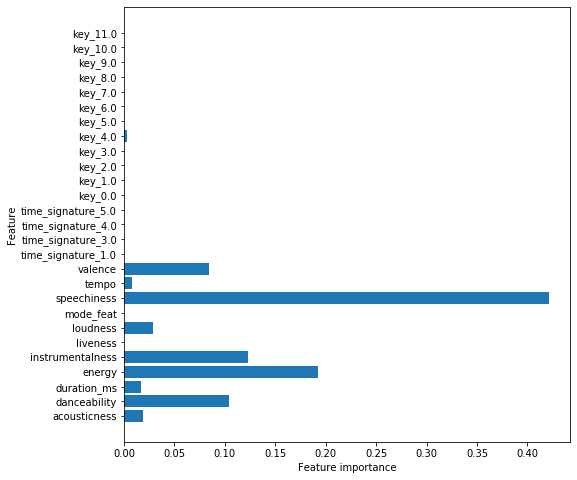

In [28]:
import matplotlib.pyplot as plt
def plot_feature_importances(model):
    n_features = X_train.shape[1]
    plt.figure(figsize=(8,8))
    plt.barh(range(n_features), model.feature_importances_, align='center') 
    plt.yticks(np.arange(n_features), X_train.columns.values) 
    plt.xlabel("Feature importance")
    plt.ylabel("Feature")

plot_feature_importances(tree_clf);

## Random Forest

In [31]:
from sklearn.ensemble import RandomForestClassifier

forest = RandomForestClassifier(n_estimators=100, 
                                max_depth= 5, 
                                bootstrap=True,
                                oob_score=True,
                                n_jobs=-1,
                                random_state=11,
                                class_weight='balanced')
forest.fit(X_train, y_train)
forest.score(X_train, y_train)

pred_forest = forest.predict(X_train)
print(confusion_matrix(y_train, pred_forest))
print(classification_report(y_train, pred_forest))

[[ 175  341  216  387  142  322  226  189]
 [  62  849  345  187  146  366  133  418]
 [  18  277 1965   37  118   54   26  137]
 [  33   55   20 1279   89  188  178   60]
 [  23  179  181  244  366  121  240  225]
 [  30  134   36  268   78  840  344  117]
 [  12  101   43  151  153  197  544  150]
 [  20  195  183   43  100  138  134 1358]]
              precision    recall  f1-score   support

           0       0.47      0.09      0.15      1998
           1       0.40      0.34      0.37      2506
           2       0.66      0.75      0.70      2632
           3       0.49      0.67      0.57      1902
           4       0.31      0.23      0.26      1579
           5       0.38      0.45      0.41      1847
           6       0.30      0.40      0.34      1351
           7       0.51      0.63      0.56      2171

    accuracy                           0.46     15986
   macro avg       0.44      0.45      0.42     15986
weighted avg       0.46      0.46      0.44     15986

